In [2]:
"""
ML for Geospatial Exposure Analysis & Risk Accumulation
Hands-on Toy Workshop for ETH CAS ML in Finance and Insurance

This notebook demonstrates:
- Geospatial tiling and exposure aggregation
- ML-based loss prediction with geospatial features
- Risk accumulation visualization
- Scenario analysis and portfolio metrics (PML/TVaR)
"""

# ========= 0) Setup & sanity checks =========
import warnings, sys, math, os, json, random
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
np.random.seed(42)
random.seed(42)

# Print versions for reproducibility
import sklearn
print("Python:", sys.version.split()[0])
print("numpy:", np.__version__, "| pandas:", pd.__version__, "| sklearn:", sklearn.__version__)

def quick_hist(y, title):
    """Helper function for quick histogram plots"""
    plt.figure(figsize=(8, 4))
    plt.hist(y, bins=30, alpha=0.8, edgecolor='black')
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.grid(True, alpha=0.3)
    plt.show()

print("✓ Setup complete!")

Python: 3.12.11
numpy: 2.0.2 | pandas: 2.2.2 | sklearn: 1.6.1
✓ Setup complete!


In [4]:
# ========= 1) Data: Load or generate synthetic portfolio =========

# Configuration
CSV_PATH = None  # Set to your CSV path, or leave None for synthetic data
BBOX = (51.2, 51.7, -0.5, 0.3)  # Greater London area (lat_min, lat_max, lon_min, lon_max)
N_POLICIES = 1500

required_cols = {'policy_id', 'lat', 'lon', 'tsi'}

def load_or_synthesize(csv_path=None, n=N_POLICIES, bbox=BBOX):
    """
    Load real portfolio or generate synthetic data for the workshop
    """
    if csv_path and os.path.exists(csv_path):
        print(f"Loading data from {csv_path}...")
        df = pd.read_csv(csv_path)
        miss = required_cols - set(df.columns)
        if miss:
            raise ValueError(f"Missing required columns in CSV: {miss}")
        df = df.dropna(subset=['lat','lon','tsi']).copy()
        df['tsi'] = df['tsi'].clip(lower=0)
        return df

    # Generate synthetic portfolio
    print(f"Generating synthetic portfolio with {n} policies...")
    lat_min, lat_max, lon_min, lon_max = bbox

    # Basic policy attributes
    policy_id = np.arange(1, n+1)
    lat = np.random.uniform(lat_min, lat_max, size=n)
    lon = np.random.uniform(lon_min, lon_max, size=n)

    # Sum insured (right-skewed distribution)
    tsi = np.exp(np.random.normal(11, 0.8, size=n)) / 100

    # Categorical features
    construction = np.random.choice(['RC','Steel','Wood','Masonry'], size=n, p=[0.45,0.25,0.15,0.15])
    occupancy = np.random.choice(['Res','Com','Ind'], size=n, p=[0.6,0.3,0.1])
    year_built = np.random.randint(1960, 2024, size=n)

    # Create latent "hazard surface" using Gaussian bumps (simulating flood zones, etc.)
    def gaussian_hazard(lat, lon, center_lat, center_lon, sigma=0.03):
        return np.exp(-(((lat-center_lat)**2 + (lon-center_lon)**2) / (2*sigma**2)))

    hazard = (
        0.9 * gaussian_hazard(lat, lon, 51.50, -0.1, 0.035) +    # Central London hazard
        0.6 * gaussian_hazard(lat, lon, 51.40, -0.25, 0.030) +   # Secondary hazard zone
        0.2 * np.random.rand(n)                                   # Base hazard noise
    )

    # Vulnerability factors based on construction and occupancy
    vuln_construction = {'RC': 0.8, 'Steel': 1.0, 'Wood': 1.2, 'Masonry': 1.1}
    vuln_occupancy = {'Res': 1.0, 'Com': 1.1, 'Ind': 1.2}

    vulnerability = (
        np.array([vuln_construction[c] for c in construction]) *
        np.array([vuln_occupancy[o] for o in occupancy])
    )

    # Generate losses: hazard * vulnerability * random component
    severity_fraction = np.clip(
        hazard * vulnerability * np.random.lognormal(mean=-1.0, sigma=0.5, size=n),
        0, 0.95
    )
    loss = tsi * severity_fraction

    df = pd.DataFrame({
        'policy_id': policy_id,
        'lat': lat,
        'lon': lon,
        'tsi': tsi,
        'construction': construction,
        'occupancy': occupancy,
        'year_built': year_built,
        'hazard_latent': hazard,
        'loss': loss
    })

    return df

Generating synthetic portfolio with 1500 policies...
Portfolio loaded: 1500 policies

First few rows:
   policy_id        lat       lon          tsi construction occupancy  \
0          1  51.387270 -0.084735  1397.973436         Wood       Res   
1          2  51.675357 -0.116654   980.864743           RC       Res   
2          3  51.565997 -0.479486  1034.512182           RC       Res   

   year_built  hazard_latent       loss  
0        1976       0.011534   4.997299  
1        1983       0.081853  71.334894  
2        1987       0.057839  20.737437  

EXPLORATORY DATA ANALYSIS


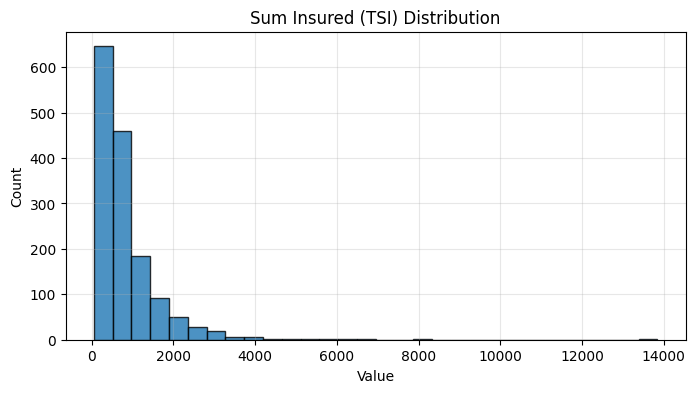

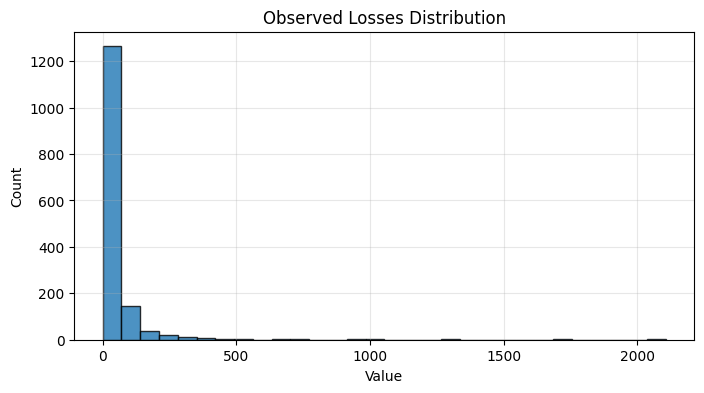


Portfolio Statistics:
• Total Sum Insured: $1,241,661
• Total Losses: $70,443
• Mean Loss Ratio: 5.7%
• Average TSI per policy: $828

Data Summary:
       policy_id      lat      lon       tsi  year_built  hazard_latent  \
count    1500.00  1500.00  1500.00   1500.00     1500.00        1500.00   
mean      750.50    51.45    -0.10    827.77     1991.87           0.13   
std       433.16     0.15     0.23    824.82       18.74           0.13   
min         1.00    51.20    -0.50     54.70     1960.00           0.00   
25%       375.75    51.32    -0.29    337.08     1975.00           0.06   
50%       750.50    51.45    -0.10    592.80     1991.00           0.11   
75%      1125.25    51.58     0.10   1022.05     2009.00           0.16   
max      1500.00    51.70     0.30  13846.95     2023.00           0.98   

          loss  
count  1500.00  
mean     46.96  
std     108.22  
min       0.01  
25%       8.86  
50%      20.57  
75%      45.78  
max    2108.70  


In [5]:
# Load or generate data
df = load_or_synthesize(CSV_PATH)
print(f"Portfolio loaded: {df.shape[0]} policies")
print("\nFirst few rows:")
print(df.head(3))

# ========= EDA: Explore the data =========

print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Distribution plots
quick_hist(df['tsi'], "Sum Insured (TSI) Distribution")
quick_hist(df['loss'], "Observed Losses Distribution")

# Summary statistics
loss_ratio_mean = df['loss'].sum() / df['tsi'].sum()
print(f"\nPortfolio Statistics:")
print(f"• Total Sum Insured: ${df['tsi'].sum():,.0f}")
print(f"• Total Losses: ${df['loss'].sum():,.0f}")
print(f"• Mean Loss Ratio: {loss_ratio_mean:.1%}")
print(f"• Average TSI per policy: ${df['tsi'].mean():,.0f}")

print(f"\nData Summary:")
print(df.describe().round(2))


GEOSPATIAL TILING & ACCUMULATION
Created 1267 unique tiles with size 0.01°

Top 5 tiles by exposure:
    tile_id  policy_count       tsi_sum  loss_ratio
215   17_57             1  13846.945962    0.071367
706   35_41             2   8691.612119    0.255954
389   23_43             3   6850.865647    0.193824
25     0_70             1   6522.656536    0.260750
654   33_44             1   6336.648971    0.148336


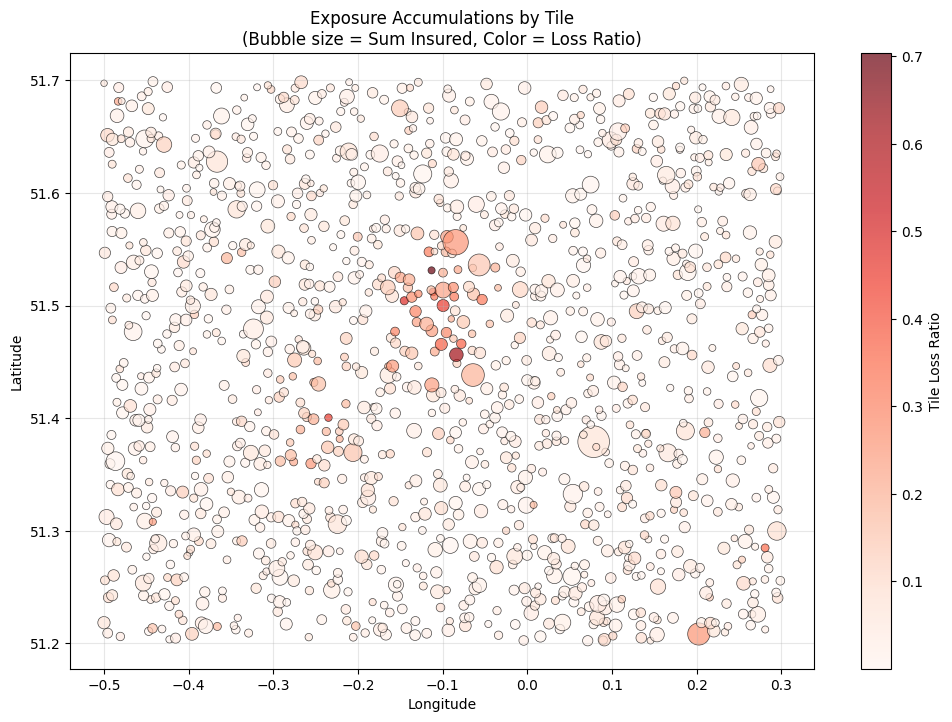

In [6]:
# ========= 2) Geospatial Tiling for Accumulation Analysis =========

print("\n" + "="*50)
print("GEOSPATIAL TILING & ACCUMULATION")
print("="*50)

# Tile configuration
TILE_DEG = 0.01  # ~1.1 km at mid-latitudes

# Create fixed reference point for stable tile indices
lat0, lon0 = float(df['lat'].min()), float(df['lon'].min())

def to_tile_fixed(lat, lon, tile_size=TILE_DEG, lat0=lat0, lon0=lon0):
    """Convert lat/lon to tile indices"""
    i = np.floor((lat - lat0) / tile_size).astype(int)
    j = np.floor((lon - lon0) / tile_size).astype(int)
    return i, j

# Assign policies to tiles
tile_i, tile_j = to_tile_fixed(df['lat'].values, df['lon'].values, TILE_DEG, lat0, lon0)
df['tile_i'] = tile_i
df['tile_j'] = tile_j
df['tile_id'] = df['tile_i'].astype(str) + "_" + df['tile_j'].astype(str)

print(f"Created {df['tile_id'].nunique()} unique tiles with size {TILE_DEG}°")

# Aggregate exposures by tile
tile_agg = (df
    .groupby('tile_id', as_index=False)
    .agg(
        lat_center=('lat', 'mean'),
        lon_center=('lon', 'mean'),
        policy_count=('policy_id', 'count'),
        tsi_sum=('tsi', 'sum'),
        loss_sum=('loss', 'sum')
    ))

tile_agg['loss_ratio'] = (tile_agg['loss_sum'] / tile_agg['tsi_sum']).fillna(0)

print("\nTop 5 tiles by exposure:")
print(tile_agg.sort_values('tsi_sum', ascending=False)[['tile_id', 'policy_count', 'tsi_sum', 'loss_ratio']].head())

# Visualize exposure accumulations
plt.figure(figsize=(12, 8))
scatter_size = (tile_agg['tsi_sum'] / tile_agg['tsi_sum'].max()) * 500 + 20
scatter = plt.scatter(
    tile_agg['lon_center'],
    tile_agg['lat_center'],
    s=scatter_size,
    c=tile_agg['loss_ratio'],
    cmap='Reds',
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)
plt.colorbar(scatter, label='Tile Loss Ratio')
plt.title("Exposure Accumulations by Tile\n(Bubble size = Sum Insured, Color = Loss Ratio)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, alpha=0.3)
plt.show()


MACHINE LEARNING MODEL TRAINING
Training set: 1200 policies
Test set: 300 policies
Training HistGradientBoosting model...

Model Performance:
• MAE: $22
• RMSE: $42
• R²: 0.351
• Baseline MAE: $39
• Improvement: 42.6%


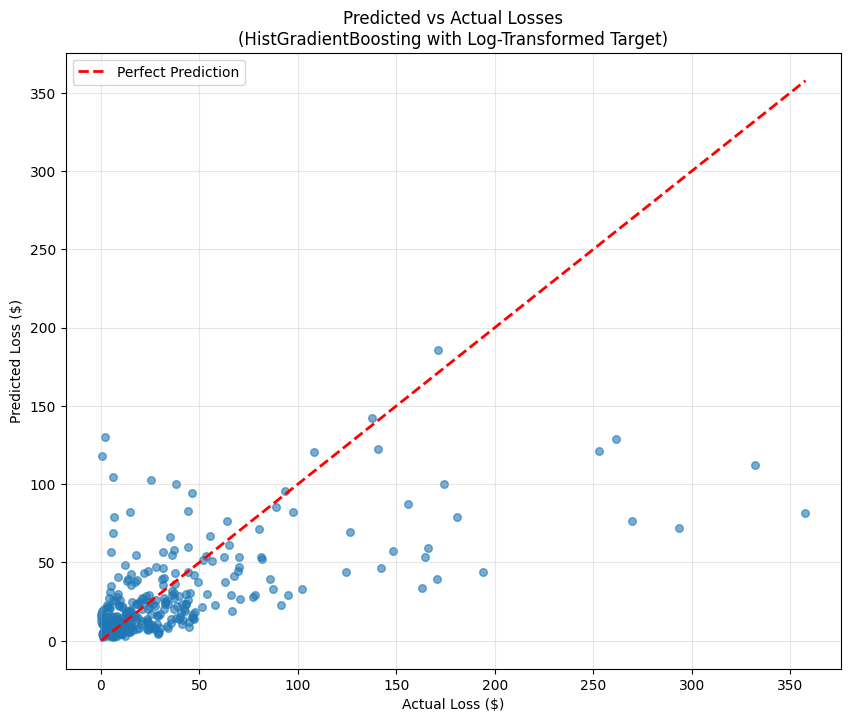

In [7]:
# ========= 3) Machine Learning Model for Loss Prediction =========

print("\n" + "="*50)
print("MACHINE LEARNING MODEL TRAINING")
print("="*50)

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
import inspect as _ins

# Prepare features and target
feature_cols = ['lat', 'lon', 'tsi', 'construction', 'occupancy', 'year_built']
X = df[feature_cols].copy()
y = df['loss'].values

numerical_features = ['lat', 'lon', 'tsi', 'year_built']
categorical_features = ['construction', 'occupancy']

# Handle sklearn version compatibility
_params = _ins.signature(OneHotEncoder).parameters
if 'sparse_output' in _params:
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
else:
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Create preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', 'passthrough', numerical_features),
    ('cat', encoder, categorical_features)
])

# Model with log-transformed target for better performance on skewed data
model = HistGradientBoostingRegressor(
    max_depth=6,
    learning_rate=0.08,
    max_bins=128,
    l2_regularization=0.0,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

# Complete pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Log-transform target to handle skewness
y_log = np.log1p(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42, stratify=df['construction']
)

print(f"Training set: {X_train.shape[0]} policies")
print(f"Test set: {X_test.shape[0]} policies")

# Train model
print("Training HistGradientBoosting model...")
pipeline.fit(X_train, y_train)

# Make predictions
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

# Calculate metrics
mae = mean_absolute_error(y_test_original, y_pred)
# Use squared=False for RMSE in older sklearn versions, or root the MSE for newer ones
# Check if squared parameter exists in mean_squared_error
import inspect
if 'squared' in inspect.signature(mean_squared_error).parameters:
    rmse = mean_squared_error(y_test_original, y_pred, squared=False)
else:
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))

r2 = r2_score(y_test_original, y_pred)

print(f"\nModel Performance:")
print(f"• MAE: ${mae:,.0f}")
print(f"• RMSE: ${rmse:,.0f}")
print(f"• R²: {r2:.3f}")

# Baseline comparison
baseline_pred = np.full_like(y_pred, np.expm1(y_train).mean())
baseline_mae = mean_absolute_error(y_test_original, baseline_pred)
improvement = (baseline_mae - mae) / baseline_mae * 100 if baseline_mae > 0 else 0

print(f"• Baseline MAE: ${baseline_mae:,.0f}")
print(f"• Improvement: {improvement:.1f}%")

# Generate predictions for entire portfolio
df['pred_loss'] = np.expm1(pipeline.predict(X))

# Predicted vs Actual scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test_original, y_pred, alpha=0.6, s=30)
max_val = max(float(y_test_original.max()), float(y_pred.max()))
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel("Actual Loss ($)")
plt.ylabel("Predicted Loss ($)")
plt.title("Predicted vs Actual Losses\n(HistGradientBoosting with Log-Transformed Target)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Feature importance (if available)
if hasattr(pipeline.named_steps['model'], 'feature_importances_'):
    feature_names = (numerical_features +
                    list(pipeline.named_steps['preprocessor']
                         .named_transformers_['cat']
                         .get_feature_names_out(categorical_features)))

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': pipeline.named_steps['model'].feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'][:10], importance_df['importance'][:10])
    plt.title("Top 10 Feature Importances")
    plt.xlabel("Importance")
    plt.gca().invert_yaxis()
    plt.show()

In [8]:
# ========= 4) Predicted Risk Accumulation Analysis =========

print("\n" + "="*50)
print("PREDICTED RISK ACCUMULATION")
print("="*50)

# Aggregate predicted losses by tile
pred_tile_agg = (df
    .groupby('tile_id', as_index=False)
    .agg(
        lat_center=('lat', 'mean'),
        lon_center=('lon', 'mean'),
        pred_loss_sum=('pred_loss', 'sum'),
        actual_loss_sum=('loss', 'sum'),
        tsi_sum=('tsi', 'sum'),
        policy_count=('policy_id', 'count')
    ))

print(f"Top 5 tiles by predicted loss:")
print(pred_tile_agg.sort_values('pred_loss_sum', ascending=False)
      [['tile_id', 'policy_count', 'pred_loss_sum', 'actual_loss_sum']].head())


PREDICTED RISK ACCUMULATION
Top 5 tiles by predicted loss:
    tile_id  policy_count  pred_loss_sum  actual_loss_sum
706   35_41             2     667.413614      2224.657198
389   23_43             3     593.920935      1327.865112
654   33_44             1     559.438514       939.951644
524   29_40             1     314.418680       703.341740
705   35_40             1     303.614121       409.419037


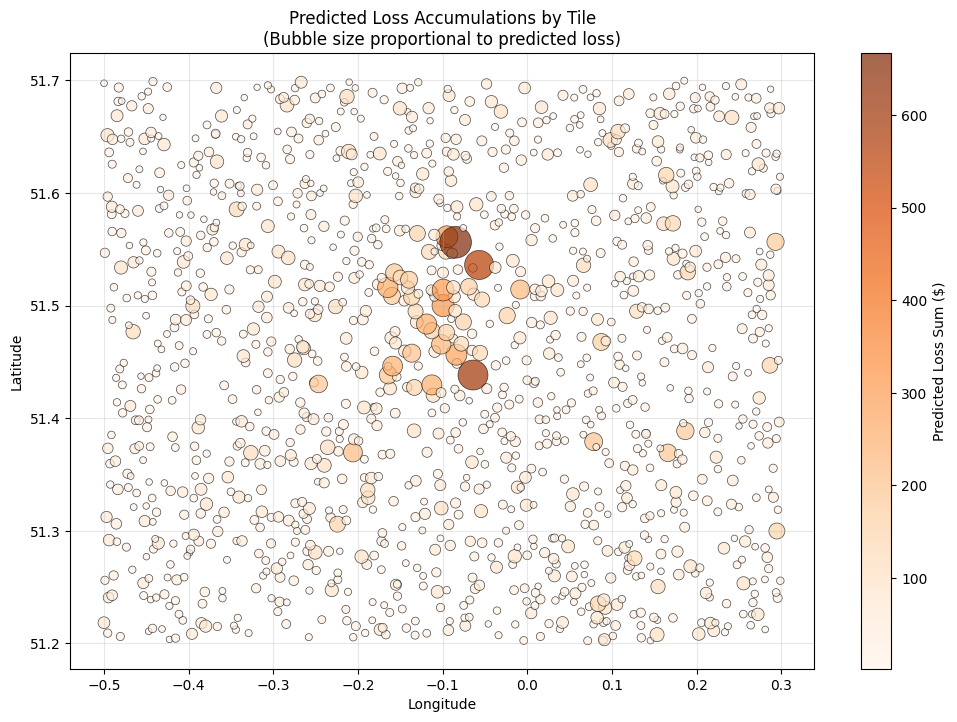

In [9]:
# Predicted accumulation visualization
plt.figure(figsize=(12, 8))
scatter_size = (pred_tile_agg['pred_loss_sum'] / pred_tile_agg['pred_loss_sum'].max()) * 500 + 20
scatter = plt.scatter(
    pred_tile_agg['lon_center'],
    pred_tile_agg['lat_center'],
    s=scatter_size,
    c=pred_tile_agg['pred_loss_sum'],
    cmap='Oranges',
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)
plt.colorbar(scatter, label='Predicted Loss Sum ($)')
plt.title("Predicted Loss Accumulations by Tile\n(Bubble size proportional to predicted loss)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, alpha=0.3)
plt.show()


ENHANCED VISUALIZATIONS


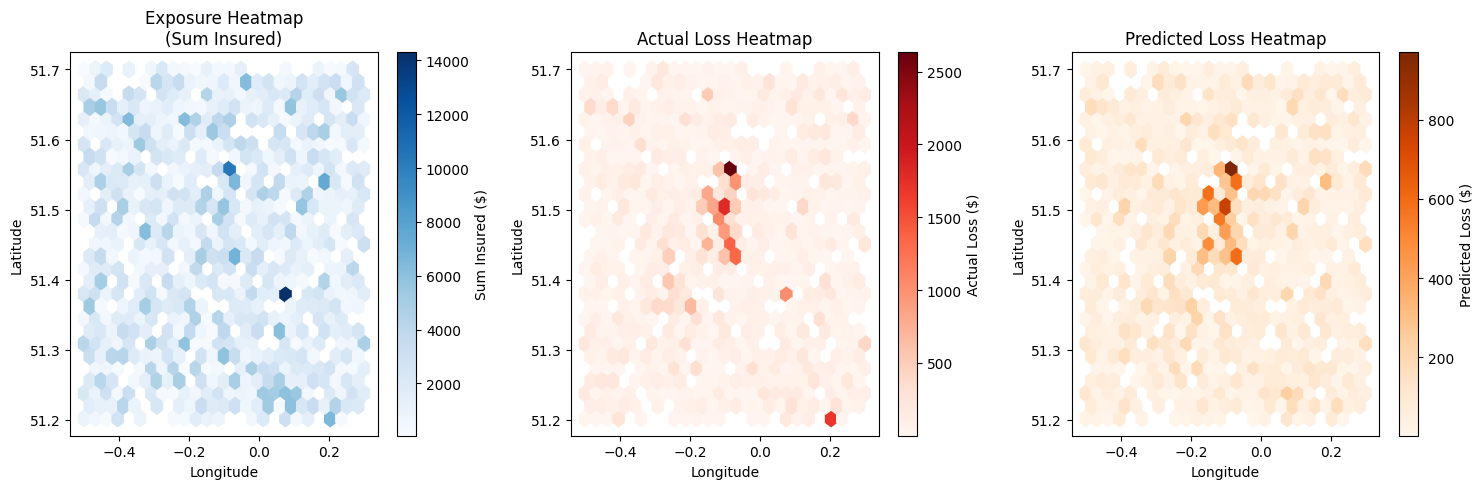

In [10]:
# ========= 5) Enhanced Visualizations =========

print("\n" + "="*50)
print("ENHANCED VISUALIZATIONS")
print("="*50)

# Hexbin exposure heatmap
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
hb1 = plt.hexbin(df['lon'], df['lat'], C=df['tsi'], reduce_C_function=np.sum,
                 gridsize=25, cmap='Blues')
plt.colorbar(hb1, label="Sum Insured ($)")
plt.title("Exposure Heatmap\n(Sum Insured)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.subplot(1, 3, 2)
hb2 = plt.hexbin(df['lon'], df['lat'], C=df['loss'], reduce_C_function=np.sum,
                 gridsize=25, cmap='Reds')
plt.colorbar(hb2, label="Actual Loss ($)")
plt.title("Actual Loss Heatmap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.subplot(1, 3, 3)
hb3 = plt.hexbin(df['lon'], df['lat'], C=df['pred_loss'], reduce_C_function=np.sum,
                 gridsize=25, cmap='Oranges')
plt.colorbar(hb3, label="Predicted Loss ($)")
plt.title("Predicted Loss Heatmap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.tight_layout()
plt.show()


SCENARIO ANALYSIS & PORTFOLIO METRICS
Applying shock scenario:
• Center: (51.45, -0.1)
• Radius: 0.05° (~5.6 km)
• Multiplier: 1.8x

40 policies affected by shock (2.7% of portfolio)

Portfolio Metrics (99th percentile):
• Baseline PML: $185
• Baseline TVaR: $293
• Shocked PML: $246 (++32.4%)
• Shocked TVaR: $374 (++28.0%)

Total Portfolio Loss:
• Baseline: $47,271
• Shocked: $50,080 (++5.9%)


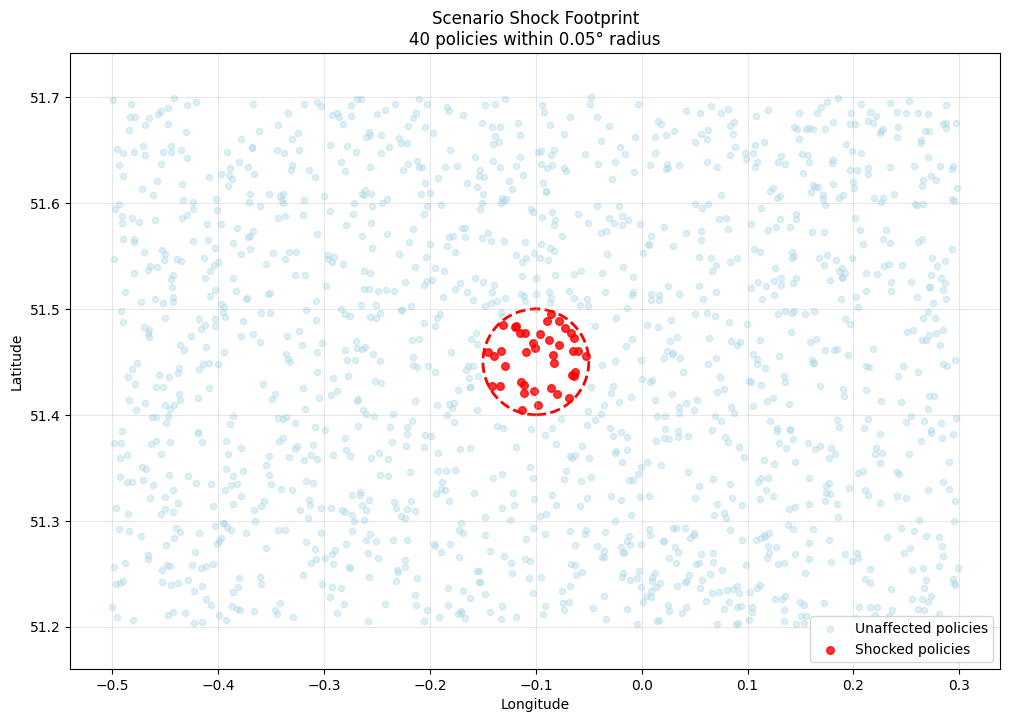

In [11]:
# ========= 6) Scenario Analysis & Portfolio Metrics =========

print("\n" + "="*50)
print("SCENARIO ANALYSIS & PORTFOLIO METRICS")
print("="*50)

def apply_radial_shock(df, center=(51.45, -0.1), radius_deg=0.05, shock_multiplier=1.8):
    """
    Apply a circular shock to the portfolio
    """
    lat_center, lon_center = center

    # Calculate distance from shock center
    distances = np.sqrt((df['lat'] - lat_center)**2 + (df['lon'] - lon_center)**2)
    within_radius = distances <= radius_deg

    # Apply shock to predicted losses
    shocked_losses = df['pred_loss'].copy()
    shocked_losses.loc[within_radius] = np.minimum(
        shocked_losses.loc[within_radius] * shock_multiplier,
        df.loc[within_radius, 'tsi'] * 0.95  # Cap at 95% of TSI
    )

    return shocked_losses, within_radius

def calculate_portfolio_metrics(losses, quantile=0.99):
    """
    Calculate PML (Probable Maximum Loss) and TVaR (Tail Value at Risk)
    """
    pml = np.quantile(losses, quantile)
    tail_losses = losses[losses >= pml]
    tvar = tail_losses.mean() if len(tail_losses) > 0 else pml
    return pml, tvar

# Define shock scenario
SHOCK_CENTER = (51.45, -0.1)  # Central London
SHOCK_RADIUS = 0.05  # ~5.5 km
SHOCK_MULTIPLIER = 1.8

print(f"Applying shock scenario:")
print(f"• Center: {SHOCK_CENTER}")
print(f"• Radius: {SHOCK_RADIUS}° (~{SHOCK_RADIUS * 111:.1f} km)")
print(f"• Multiplier: {SHOCK_MULTIPLIER}x")

# Apply shock
df['pred_loss_shocked'], shock_mask = apply_radial_shock(
    df, center=SHOCK_CENTER, radius_deg=SHOCK_RADIUS, shock_multiplier=SHOCK_MULTIPLIER
)

print(f"\n{shock_mask.sum()} policies affected by shock ({shock_mask.mean():.1%} of portfolio)")
# Calculate portfolio metrics
pml_baseline, tvar_baseline = calculate_portfolio_metrics(df['pred_loss'].values)
pml_shocked, tvar_shocked = calculate_portfolio_metrics(df['pred_loss_shocked'].values)

print(f"\nPortfolio Metrics (99th percentile):")
print(f"• Baseline PML: ${pml_baseline:,.0f}")
print(f"• Baseline TVaR: ${tvar_baseline:,.0f}")
print(f"• Shocked PML: ${pml_shocked:,.0f} (+{((pml_shocked/pml_baseline-1)*100):+.1f}%)")
print(f"• Shocked TVaR: ${tvar_shocked:,.0f} (+{((tvar_shocked/tvar_baseline-1)*100):+.1f}%)")

total_baseline = df['pred_loss'].sum()
total_shocked = df['pred_loss_shocked'].sum()
print(f"\nTotal Portfolio Loss:")
print(f"• Baseline: ${total_baseline:,.0f}")
print(f"• Shocked: ${total_shocked:,.0f} (+{((total_shocked/total_baseline-1)*100):+.1f}%)")

# Visualize shock footprint
plt.figure(figsize=(12, 8))
plt.scatter(df.loc[~shock_mask, 'lon'], df.loc[~shock_mask, 'lat'],
           s=20, alpha=0.4, label='Unaffected policies', c='lightblue')
plt.scatter(df.loc[shock_mask, 'lon'], df.loc[shock_mask, 'lat'],
           s=30, alpha=0.8, label='Shocked policies', c='red')

# Draw shock circle
circle = plt.Circle(SHOCK_CENTER[::-1], SHOCK_RADIUS, fill=False,
                   color='red', linestyle='--', linewidth=2)
plt.gca().add_patch(circle)

plt.title(f"Scenario Shock Footprint\n{shock_mask.sum()} policies within {SHOCK_RADIUS}° radius")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

In [12]:
# ========= 7) Export Results & Checkpoints =========

print("\n" + "="*50)
print("RESULTS EXPORT & WORKSHOP CHECKPOINTS")
print("="*50)

# Export top risk tiles
top_tiles = pred_tile_agg.sort_values('pred_loss_sum', ascending=False).head(10)
print("Top 10 risk accumulation tiles:")
print(top_tiles[['tile_id', 'lat_center', 'lon_center', 'policy_count', 'pred_loss_sum']].round(2))


RESULTS EXPORT & WORKSHOP CHECKPOINTS
Top 10 risk accumulation tiles:
    tile_id  lat_center  lon_center  policy_count  pred_loss_sum
706   35_41       51.56       -0.08             2         667.41
389   23_43       51.44       -0.06             3         593.92
654   33_44       51.54       -0.06             1         559.44
524   29_40       51.50       -0.10             1         314.42
705   35_40       51.56       -0.09             1         303.61
599   31_40       51.51       -0.10             1         302.13
435   25_41       51.46       -0.08             1         278.00
596   31_33       51.52       -0.16             1         258.82
497   28_38       51.48       -0.12             2         255.74
366   22_38       51.43       -0.11             2         252.95


In [13]:
print(f"\n🏁 WORKSHOP CHECKPOINTS:")
print(f"⚑ Change TILE_DEG to 0.005 and re-run accumulation analysis")
print(f"⚑ Try different ML models (RandomForest, XGBoost) and compare performance")
print(f"⚑ Create shock scenarios at different locations and assess impact")
print(f"⚑ Add engineered features: distance to city center, elevation, etc.")
print(f"⚑ Implement per-peril models for flood, wind, earthquake")
print(f"⚑ Add temporal features and time-aware validation")

print(f"\n✅ Workshop complete! Key results:")
print(f"• Analyzed {df.shape[0]} policies across {df['tile_id'].nunique()} tiles")
print(f"• ML model achieved {r2:.1%} R² with ${mae:,.0f} MAE")
print(f"• Identified top risk accumulation zones")
print(f"• Quantified scenario impact: +{((total_shocked/total_baseline-1)*100):+.1f}% portfolio loss")

print(f"\n🔬 Next steps for production:")
print(f"• Replace synthetic data with real portfolio")
print(f"• Implement proper geospatial libraries (geopandas, h3)")
print(f"• Add model governance, calibration, and bias testing")
print(f"• Build real-time monitoring and alerting systems")


🏁 WORKSHOP CHECKPOINTS:
⚑ Change TILE_DEG to 0.005 and re-run accumulation analysis
⚑ Try different ML models (RandomForest, XGBoost) and compare performance
⚑ Create shock scenarios at different locations and assess impact
⚑ Add engineered features: distance to city center, elevation, etc.
⚑ Implement per-peril models for flood, wind, earthquake
⚑ Add temporal features and time-aware validation

✅ Workshop complete! Key results:
• Analyzed 1500 policies across 1267 tiles
• ML model achieved 35.1% R² with $22 MAE
• Identified top risk accumulation zones
• Quantified scenario impact: ++5.9% portfolio loss

🔬 Next steps for production:
• Replace synthetic data with real portfolio
• Implement proper geospatial libraries (geopandas, h3)
• Add model governance, calibration, and bias testing
• Build real-time monitoring and alerting systems
